# AEESP Workshop Tutorial on WaterTAP
## Prerequisites
### * Python
### * Pyomo
### * IDAES

## Pyomo Example

<div>
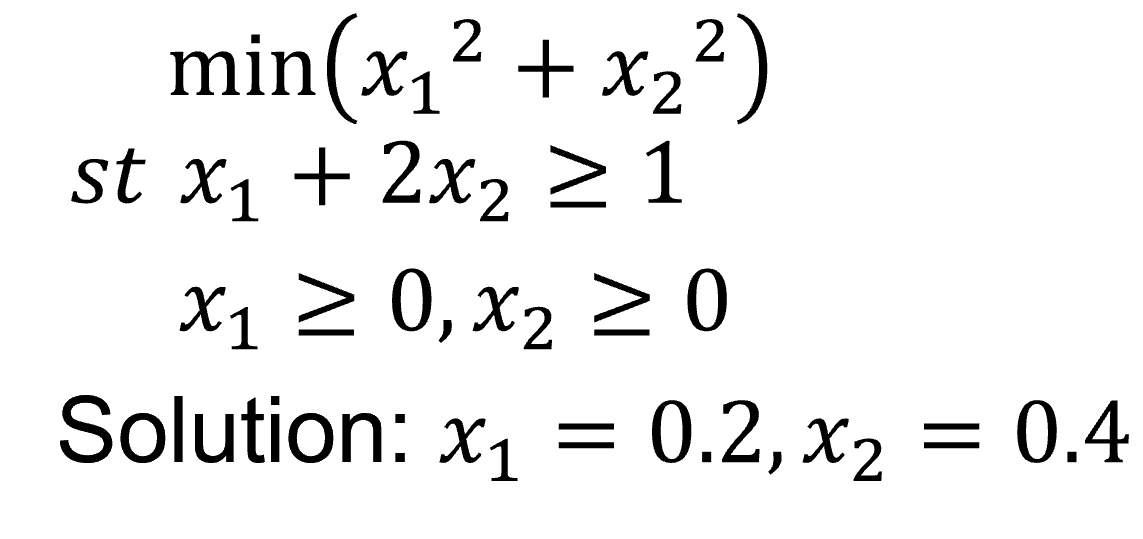
</div>


In [ ]:
from pyomo.environ import ConcreteModel, Var, Constraint, Objective, NonNegativeReals
from idaes.core.util import get_solver
solver = get_solver()

In [ ]:
m = ConcreteModel()

In [ ]:
m.x = Var([1, 2], domain=NonNegativeReals)

In [ ]:
m.Obj = Objective(expr=m.x[1]**2 + m.x[2]**2)

In [ ]:
m.Con = Constraint(expr=m.x[1] + 2*m.x[2] >= 1)

In [15]:
solver.solve(m)

NameError: name 'solver' is not defined

## Introduction to the Reverse Osmosis Unit Model
This tutorial shows how to build, initialize, simulate, and optimize a reverse osmosis (RO) unit model using WaterTAP. In this example, we will minimize the specific energy consumption of the RO unit.

### Step 1: Import libraries.

In [1]:
# Imports from Pyomo, including "value" for getting the 
# value of Pyomo objects
from pyomo.environ import ConcreteModel, Objective, Expression, value

# Imports from IDAES
# Import flowsheet block from IDAES core
from idaes.core import FlowsheetBlock
# Import function to get default solver
from idaes.core.solvers import get_solver
# Import function to check degrees of freedom
from idaes.core.util.model_statistics import degrees_of_freedom
# Import utility function for calculating scaling factors
from idaes.core.util.scaling import calculate_scaling_factors

# Imports from WaterTAP
# Import NaCl property model
from watertap.property_models.NaCl_prop_pack import NaClParameterBlock
# Import RO model
from watertap.unit_models.reverse_osmosis_0D import (ReverseOsmosis0D,
        ConcentrationPolarizationType, MassTransferCoefficient)

### Step 2: Start building the RO model.

In [2]:
# Create a Pyomo concrete model, flowsheet, and NaCl property parameter block.
m = ConcreteModel()
m.fs = FlowsheetBlock(default={'dynamic':False})
m.fs.properties = NaClParameterBlock()

In [3]:
# Add an RO unit to the flowsheet.
m.fs.unit = ReverseOsmosis0D(default={
    "property_package": m.fs.properties,
    "concentration_polarization_type": ConcentrationPolarizationType.none,
    "mass_transfer_coefficient": MassTransferCoefficient.none,
    "has_pressure_change": False,
    })

### Step 3: Specify values for system variables.

In [4]:
m.fs.unit.inlet.flow_mass_phase_comp[0, 'Liq', 'NaCl'].fix(0.035)  # mass flow rate of NaCl (kg/s)
m.fs.unit.inlet.flow_mass_phase_comp[0, 'Liq', 'H2O'].fix(0.965)   # mass flow rate of water (kg/s)
m.fs.unit.inlet.pressure[0].fix(50e5)                              # feed pressure (Pa)
m.fs.unit.inlet.temperature[0].fix(298.15)                         # feed temperature (K)
m.fs.unit.area.fix(50)                                             # membrane area (m^2)
m.fs.unit.A_comp.fix(4.2e-12)                                      # membrane water permeability (m/Pa/s)
m.fs.unit.B_comp.fix(3.5e-8)                                       # membrane salt permeability (m/s)
m.fs.unit.permeate.pressure[0].fix(101325)                         # permeate pressure (Pa)

### Step 4: Scale all variables.

In [5]:
# Set scaling factors for component mass flowrates.
m.fs.properties.set_default_scaling('flow_mass_phase_comp', 1, index=('Liq', 'H2O'))
m.fs.properties.set_default_scaling('flow_mass_phase_comp', 1e2, index=('Liq', 'NaCl'))

# Calculate scaling factors for all other variables.
calculate_scaling_factors(m)

### Step 5: Initialize the model.

In [6]:
m.fs.unit.initialize()

2021-08-26 17:41:52 [INFO] idaes.init.fs.unit: Initialization Step 3 successful.
2021-08-26 17:41:52 [INFO] idaes.init.fs.unit: Initialization Complete: optimal - Optimal Solution Found


### Step 6: Setup a solver and run a simulation.

In [7]:
# Check that degrees of freedom = 0 before attempting simulation.
# This means that the performance of the flowsheet is completely
# determined by the system variables that were fixed above.
assert degrees_of_freedom(m) == 0

In [8]:
# Setup solver
solver = get_solver(options={'nlp_scaling_method': 'user-scaling'})

In [9]:
# Run simulation
simulation_results = solver.solve(m)

In [10]:
# Display all results
m.fs.unit.display()

Block fs.unit

  Variables:
    A_comp : Solvent permeability coeff.
        Size=1, Index=fs.unit.A_comp_index, Units=m**2*s/kg
        Key          : Lower : Value   : Upper : Fixed : Stale : Domain
        (0.0, 'H2O') : 1e-18 : 4.2e-12 : 1e-06 :  True :  True : NonNegativeReals
    B_comp : Solute permeability coeff.
        Size=1, Index=fs.unit.B_comp_index, Units=m/s
        Key           : Lower : Value   : Upper : Fixed : Stale : Domain
        (0.0, 'NaCl') : 1e-11 : 3.5e-08 : 1e-05 :  True :  True : NonNegativeReals
    flux_mass_phase_comp : Mass flux across membrane at inlet and outlet
        Size=4, Index=fs.unit.flux_mass_phase_comp_index, Units=kg/m**2/s
        Key                         : Lower  : Value                  : Upper : Fixed : Stale : Domain
          (0.0, 0.0, 'Liq', 'H2O') : 0.0001 :   0.008639781510640883 :  0.03 : False : False :  Reals
         (0.0, 0.0, 'Liq', 'NaCl') :  1e-08 :  1.246265261457656e-06 : 0.001 : False : False :  Reals
         (0.0

### Step 7: Unfix variables, set variable bounds, and run optimization to minimize specific energy consumption.

In [11]:
# Unfix membrane area and feed pressure
m.fs.unit.area.unfix()                  # membrane area (m^2)
m.fs.unit.inlet.pressure[0].unfix()     # feed pressure (Pa)

In [12]:
# Set lower and upper bounds for membrane area (m^2)
m.fs.unit.area.setlb(1)
m.fs.unit.area.setub(500)

In [13]:
# Set lower and upper bounds for feed pressure (Pa)
m.fs.unit.inlet.pressure[0].setlb(10e5)
m.fs.unit.inlet.pressure[0].setub(80e5)

In [14]:
# Assume 100% efficiency of pumps and ERD and no pressure losses
#--> Pump power consumption ~ Qp*Pf/3.6e6
m.fs.specific_energy_consumption = Expression(
    expr=m.fs.unit.inlet.pressure[0]/(3.6e6))

In [15]:
# Define objective function to minimize the specific energy consumption.
m.fs.objective = Objective(expr=m.fs.specific_energy_consumption)

In [16]:
# Set the water recovery to 50%
m.fs.unit.recovery_vol_phase[0,'Liq'].fix(0.50)

In [17]:
# The solver will find the membrane area and 
# inlet pressure that achieve 50% recovery while minimizing
# specific energy consumption. Since we fixed the 
# volumetric water recovery, a degree of freedom 
# was removed from the model.
print(degrees_of_freedom(m))

1


In [18]:
optimization_results = solver.solve(m)

In [19]:
# membrane area of the optimized RO unit
value(m.fs.unit.area)

143.94516285995343

In [20]:
# inlet pressure of the optimized RO unit
value(m.fs.unit.inlet.pressure[0])

4526838.692348513

In [21]:
# the minimum specific energy consumption
value(m.fs.specific_energy_consumption)

1.2574551923190314

In [22]:
# display the overall report on the RO unit
m.fs.unit.report()


Unit : fs.unit                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                                            : Value      : Fixed : Bounds
                                     Membrane Area :     143.95 : False : (1, 500)
                   NaCl Concentration @Inlet,Bulk  :     35.751 : False : (0.001, 2000.0)
     NaCl Concentration @Inlet,Membrane-Interface  :     35.751 : False : (0.001, 2000.0)
                  NaCl Concentration @Outlet,Bulk  :     70.960 : False : (0.001, 2000.0)
    NaCl Concentration @Outlet,Membrane-Interface  :     70.960 : False : (0.001, 2000.0)
                      NaCl Permeate Concentration  :    0.45419 : False : (0.001, 2000.0)
        Osmotic Pressure @Inlet,Membrane-Interface : 2.8528e+06 : False : (500.0, 50000000.0)
                     Osmotic Pressure @Outlet,Bulk : 5.8432e+06 : False : (500.0, 